### Imports

In [123]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import numpy as np
from matplotlib import pyplot as plt
from tensorflow import keras
from sklearn.svm import SVC
from hyperopt import hp
from lib.similarity import CentroidSimilarity
from utils.hyper_parameters_tuning import model_hypopt
from utils.visualization import plot_hist
from sklearn.neighbors import KNeighborsClassifier
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova,FeatureSelectionDiversityPursuitKruskal
from lib.classifier_with_feature_selection import ClassifierFeatureSelection
from utils.experiment_utils import multiple_classifiers_fit_predict
from utils.experiment_utils import get_feature_extractor, extract_features, preprocessing_model
from utils.experiment_utils import get_images_from_supervised_set
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from utils.visualization import bar_plot_scores
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load the dataset

In [82]:
# define here a location for the downloaded dataset
datasets_dir = "c:/datasets/"
if os.path.isdir(datasets_dir) is not True:
    os.mkdir(datasets_dir)

In [83]:
ds_name = 'omniglot'
omniglot_ds, omniglot_ds_info = tfds.load(ds_name, split=['train', 'test'], shuffle_files=False, with_info=True, as_supervised=True,data_dir=datasets_dir)
print(omniglot_ds_info)

tfds.core.DatasetInfo(
    name='omniglot',
    full_name='omniglot/3.0.0',
    description="""
    Omniglot data set for one-shot learning. This dataset contains 1623 different
    handwritten characters from 50 different alphabets.
    """,
    homepage='https://github.com/brendenlake/omniglot/',
    data_path='c:/datasets/omniglot\\3.0.0',
    file_format=tfrecord,
    download_size=17.95 MiB,
    dataset_size=12.29 MiB,
    features=FeaturesDict({
        'alphabet': ClassLabel(shape=(), dtype=int64, num_classes=50),
        'alphabet_char_id': int64,
        'image': Image(shape=(105, 105, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=1623),
    }),
    supervised_keys=('image', 'label'),
    disable_shuffling=False,
    splits={
        'small1': <SplitInfo num_examples=2720, num_shards=1>,
        'small2': <SplitInfo num_examples=3120, num_shards=1>,
        'test': <SplitInfo num_examples=13180, num_shards=1>,
        'train': <SplitInfo num_

In [84]:
label_set = list(range(1623))
train_images, train_labels = get_images_from_supervised_set(omniglot_ds[0], label_set, img_size=[105,105])
print(f"images shape = {train_images.shape}")
print(f"labels shape = {train_labels.shape}")

images shape = (19280, 105, 105, 3)
labels shape = (19280,)


In [87]:
# process the images - resize to the mnist size (28,28) and convert to gray scale
def preprocess_images(images):
    resized_images = tf.image.resize(images, size=[28,28], antialias=True).numpy()
    gray_images = np.expand_dims(np.dot(resized_images[...,:3], [0.2989, 0.5870, 0.1140]), axis=3)
    return gray_images

processed_train_images = preprocess_images(train_images)
print(f"processed images shape = {processed_train_images.shape}")

processed images shape = (19280, 28, 28, 1)


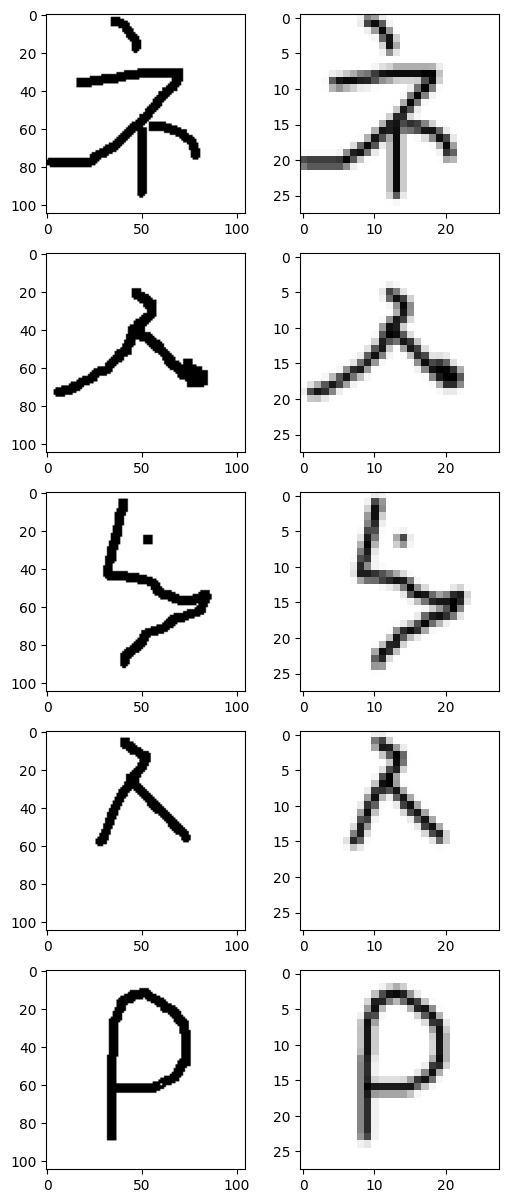

In [90]:
# plotting some examples from the data
fig, ax = plt.subplots(5,2,figsize=(6, 15))
for i in range(5):
    ax[i,1].imshow(processed_train_images[i].astype("uint8"),cmap=plt.get_cmap('gray'))
    ax[i,0].imshow(train_images[i].numpy().astype("uint8"))

### Define a feature extractor

In [91]:
model = keras.models.load_model('c:/model_checkpoints/mnist_classification_convnet')
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 26, 26, 32)        320       
                                                                 
 batch_normalization_8 (Batc  (None, 26, 26, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 13, 13, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 11, 11, 64)        18496     
                                                                 
 batch_normalization_9 (Batc  (None, 11, 11, 64)       256       
 hNormalization)                                                 
                                                      

In [92]:
feature_extractor = keras.Model(inputs=model.inputs, outputs=model.get_layer(name="flatten_layers").output)

In [95]:
def preprocess(images):
    # convert from integers to floats and scale
    return tf.cast(images,'float32') / 255.0

In [96]:
batch_size = 32
with tf.device('/cpu:0'):
    train_ds = tf.data.Dataset.from_tensor_slices(processed_train_images).batch(batch_size)
X_train = extract_features(ds=train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

In [97]:
if tf.is_tensor(train_labels):
    y_train = train_labels.numpy()
else:
    y_train = train_labels
print(f"num of labels = {len(np.unique(y_train))}")


num of labels = 964


### Experiment 1 - scanning train set size

In [98]:
# optimize a SVM classifier to the train data
svm_search_space = {'C' : hp.uniform('C',0.1,10),
                        'kernel': hp.choice('kernel',['linear', 'poly', 'rbf', 'sigmoid']),
                        'degree' : hp.choice('degree',list(range(1,10)))}
# sample a label set
label_set = np.random.choice(a=np.unique(y_train),size=5,replace=False)
smpl_idx = []
for l in label_set:
    cls_idcs = np.squeeze(np.argwhere(y_train == l))
    smpl_idx.extend(list(cls_idcs))
svm_X_train = X_train[smpl_idx]
svm_y_train = y_train[smpl_idx]

hyper_opt = model_hypopt(model=SVC,param_space=svm_search_space,X_train=svm_X_train, y_train=svm_y_train)
best_params = hyper_opt.run()

100%|██████████| 150/150 [00:12<00:00, 11.97trial/s, best loss: -0.96]


Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------






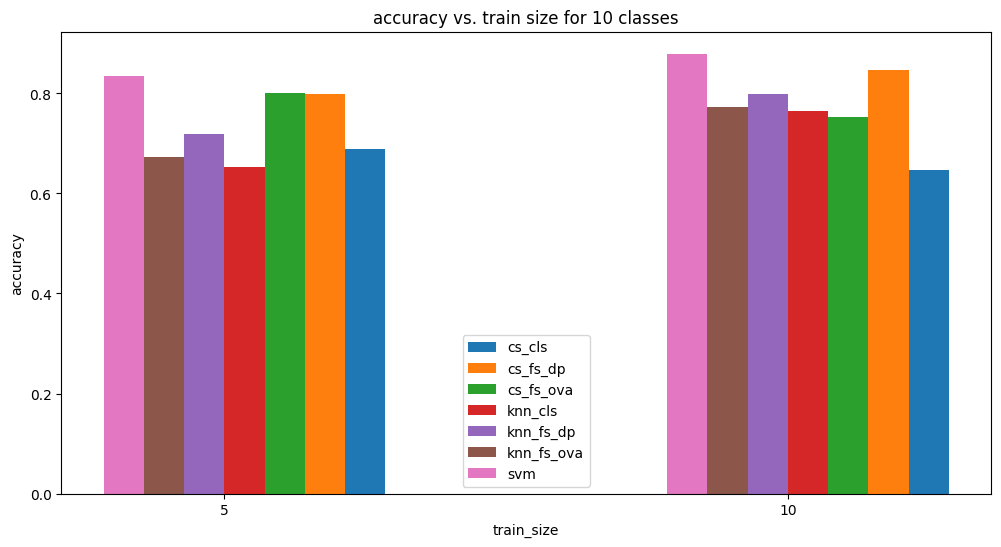

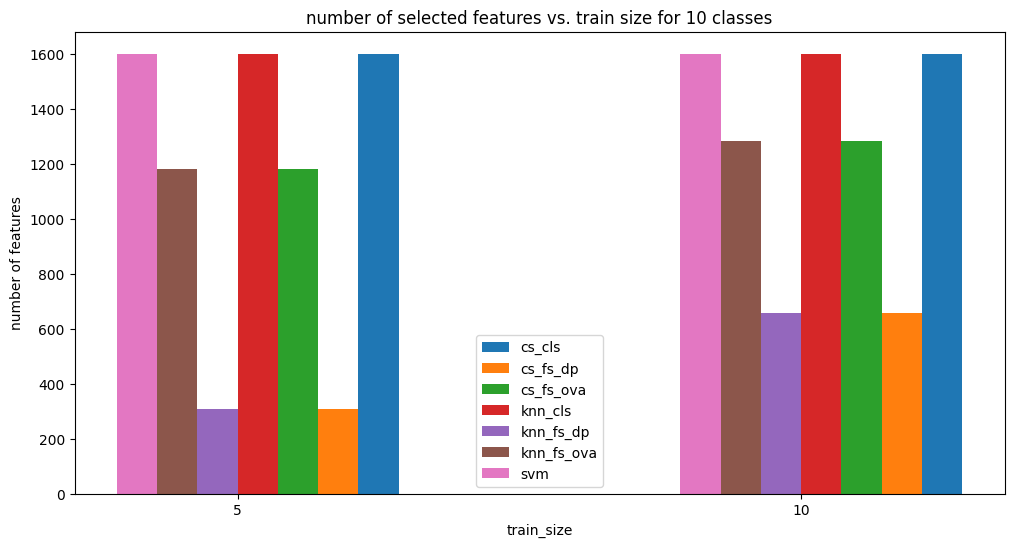

In [138]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.2
train_sizes = [5,10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
cs_cls  = CentroidSimilarity()
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(knn_cls, dp_fs)
knn_fs_ova = ClassifierFeatureSelection(knn_cls, ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
accuracies_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features_w_noise = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(cls_idcs))

        smpl_X = X_train[smpl_idx]
        smpl_y = y_train[smpl_idx]
        # calculate accuracy and get the number of features over few splits
        split_accuracies = np.empty((len(classifiers), num_splits))
        split_num_features = np.empty((len(classifiers), num_splits))
        for k in range(num_splits):
            smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(smpl_X, smpl_y, train_size=train_sizes[i]*num_classes, stratify=smpl_y)
            split_accuracies[:,k], split_num_features[:,k] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=smpl_X_test,
                                                                                              y_test=smpl_y_test)
        accuracies[:,i,j] = np.mean(split_accuracies, axis=1)
        num_features[:,i,j] = np.mean(split_num_features, axis=1)
    print("\n\n\n")


bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')

### Experiment 2 -  Classification of noisy images

In [132]:
threshold = 0.4
noise = np.random.rand(*train_images.numpy().shape[0:3])
mask = noise < threshold
mask = np.repeat(np.expand_dims(mask,axis=3), repeats=3, axis=3)


In [133]:
noisy_images = train_images.numpy()//255
noisy_images = np.logical_xor(noisy_images,mask)
noisy_images = noisy_images * 255

In [134]:
processed_noisy_train_images = preprocess_images(noisy_images)

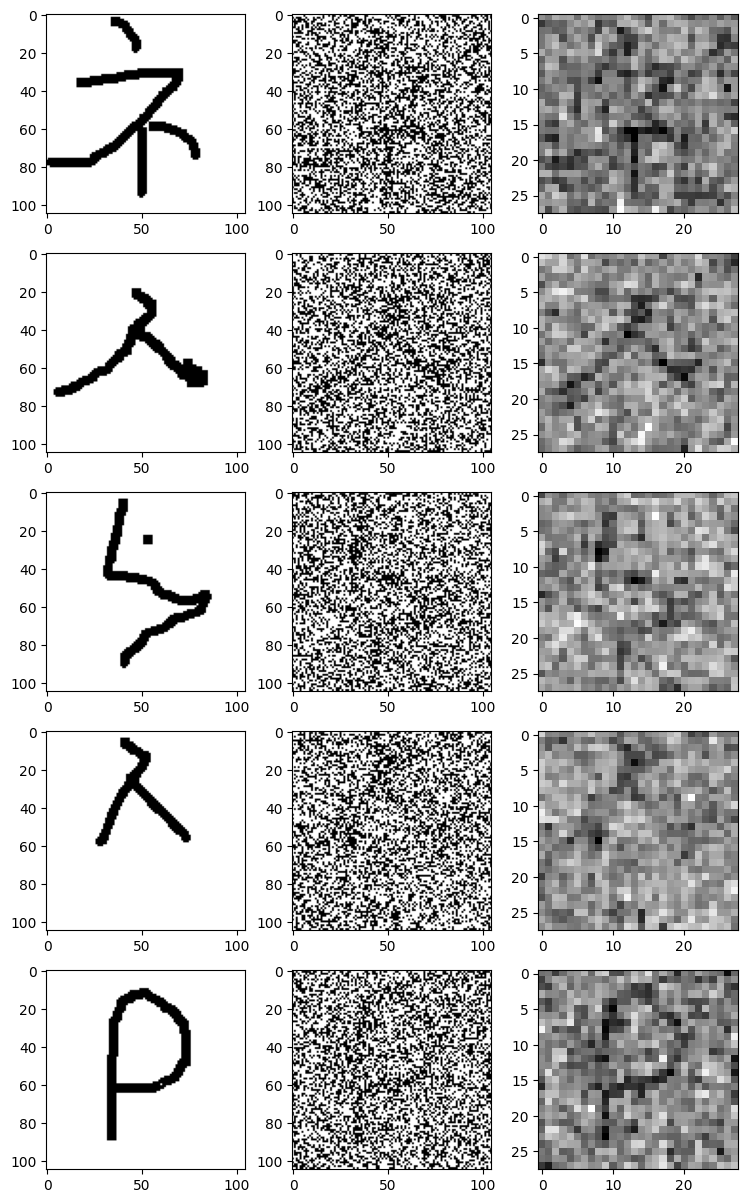

In [135]:
fig, ax = plt.subplots(5,3,figsize=(9, 15))
for i in range(5):
    ax[i,0].imshow(train_images[i].numpy().astype("uint8"))
    ax[i,1].imshow(noisy_images[i].astype("uint8"))
    ax[i,2].imshow(processed_noisy_train_images[i].astype("uint8"),cmap=plt.get_cmap('gray'))

In [136]:
batch_size = 32
with tf.device('/cpu:0'):
    noisy_train_ds = tf.data.Dataset.from_tensor_slices(processed_noisy_train_images).batch(batch_size)
X_noisy = extract_features(ds=noisy_train_ds, preprocessing_model=preprocess, feature_extractor=feature_extractor)

Measuring accuracy with 10 classes,  5 training examples per class
---------------------------------------------------------------




Measuring accuracy with 10 classes,  10 training examples per class
---------------------------------------------------------------






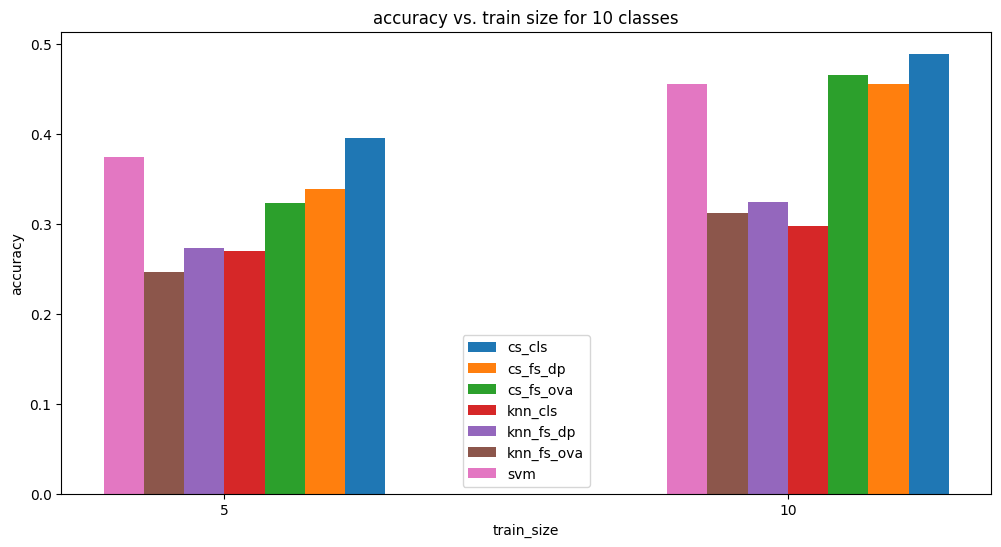

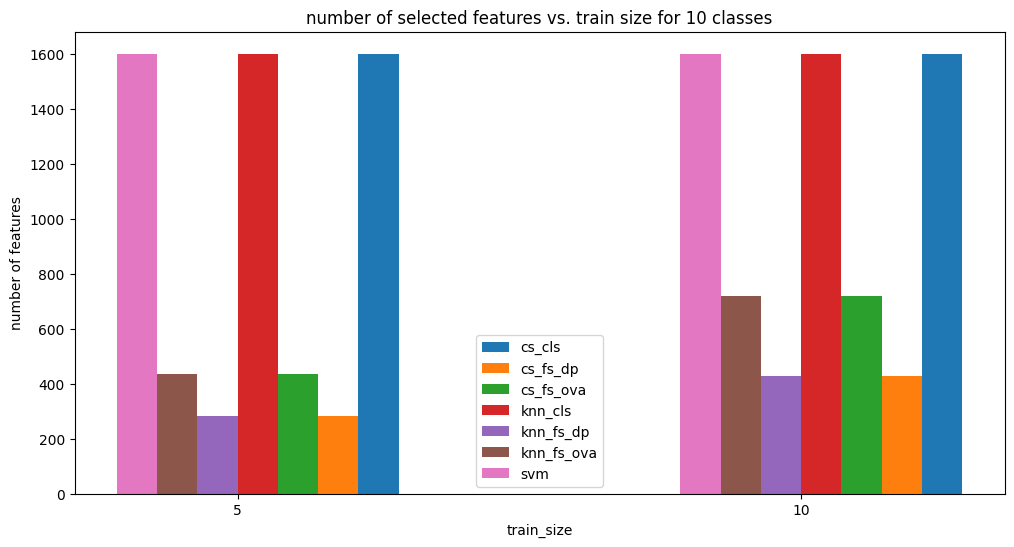

In [137]:
from lib.feature_selection import FeatureSelectionDiversityPursuitAnova,FeatureSelectionOneVsAllAnova, FeatureSelectionDiversityPursuitPermutation
gamma = 0.5
train_sizes = [5,10]
# define feature selectors
dp_fs = FeatureSelectionDiversityPursuitAnova(hc_gamma=gamma)
ova_fs = FeatureSelectionOneVsAllAnova(hc_gamma=gamma)
dp_perm_fs = FeatureSelectionDiversityPursuitPermutation(hc_gamma=gamma, n_resamples=5000)
# defining classifiers
use_euclidian_distance = False
cs_cls  = CentroidSimilarity(use_euclidian_distance=use_euclidian_distance)
cs_fs_dp = ClassifierFeatureSelection(CentroidSimilarity(use_euclidian_distance=use_euclidian_distance), dp_fs)
#cs_fs_dp_perm = ClassifierFeatureSelection(cs_cls, dp_perm_fs)
cs_fs_ova = ClassifierFeatureSelection(CentroidSimilarity(use_euclidian_distance=use_euclidian_distance), ova_fs)
knn_cls = KNeighborsClassifier(n_neighbors=train_sizes[0])
knn_fs_dp = ClassifierFeatureSelection(KNeighborsClassifier(n_neighbors=train_sizes[0]), dp_fs)
knn_fs_ova = ClassifierFeatureSelection(KNeighborsClassifier(n_neighbors=train_sizes[0]), ova_fs)
svm_cls = SVC(**best_params)
classifiers = [cs_cls, cs_fs_dp, cs_fs_ova, knn_cls, knn_fs_dp, knn_fs_ova, svm_cls]
num_experiments = 50
num_splits = 5
# define possible sizes for the train set (number of train examples per class)
num_classes = 10
accuracies = np.empty((len(classifiers),len(train_sizes),num_experiments))
num_features = np.empty((len(classifiers),len(train_sizes),num_experiments))

for i in range(len(train_sizes)):
    n = train_sizes[i]
    print(f"Measuring accuracy with {num_classes} classes,  {n} training examples per class")
    print("---------------------------------------------------------------")
    for j in range(num_experiments):
        # sample a label set
        label_set = np.random.choice(a=np.unique(y_train),size=num_classes,replace=False)
        # sample a desired number of examples (feature vectors) for each class
        smpl_idx = []
        for l in label_set:
            cls_idcs = np.squeeze(np.argwhere(y_train == l))
            smpl_idx.extend(list(cls_idcs))

        smpl_X = X_noisy[smpl_idx]
        smpl_y = y_train[smpl_idx]
        # calculate accuracy and get the number of features over few splits
        split_accuracies = np.empty((len(classifiers), num_splits))
        split_num_features = np.empty((len(classifiers), num_splits))
        for k in range(num_splits):
            smpl_X_train, smpl_X_test, smpl_y_train, smpl_y_test = train_test_split(smpl_X, smpl_y, train_size=train_sizes[i]*num_classes, stratify=smpl_y)
            split_accuracies[:,k], split_num_features[:,k] = multiple_classifiers_fit_predict(classifiers=classifiers,
                                                                                              X_train=smpl_X_train,
                                                                                              y_train=smpl_y_train,
                                                                                              X_test=smpl_X_test,
                                                                                              y_test=smpl_y_test)
        accuracies[:,i,j] = np.mean(split_accuracies, axis=1)
        num_features[:,i,j] = np.mean(split_num_features, axis=1)
    print("\n\n\n")


bar_labels = ['cs_cls', 'cs_fs_dp', 'cs_fs_ova', 'knn_cls', 'knn_fs_dp', 'knn_fs_ova', 'svm']
bar_plot_scores(scores=np.mean(accuracies,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='accuracy',
                title=f'accuracy vs. train size for {num_classes} classes')

bar_plot_scores(scores=np.mean(num_features,axis=2),
                bar_labels=bar_labels,
                xticklabels=train_sizes,
                xlabel='train_size',
                ylabel='number of features',
                title=f'number of selected features vs. train size for {num_classes} classes')